## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

## Сбор и подготовка данных

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

Заменяем пропуски значением 'unknown' для категориальных столбцов

In [5]:
df = df.fillna({'artists': 'unknown', 'album_name': 'unknown', 'track_name': 'unknown'})

Удаление ненужных колонок

In [6]:
df = df.drop(columns=['Unnamed: 0', 'track_id', 'track_name'])

df.isnull().sum()

artists             0
album_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

Преобразуем длительность из милисекунд в минуты

In [7]:
df['duration_minutes'] = (df['duration_ms'] / 60000).round(2)

# Удалим ненужный столбец
df.drop('duration_ms', axis=1, inplace=True)

df['duration_minutes']

0         3.84
1         2.49
2         3.51
3         3.37
4         3.31
          ... 
113995    6.42
113996    6.42
113997    4.52
113998    4.73
113999    4.03
Name: duration_minutes, Length: 114000, dtype: float64

## Анализ данных

### Выделим числовые и категориальные признаки

In [8]:
numerical_features = df.select_dtypes(include=['number','float64','int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object','category']).columns.tolist()

numerical_features

['popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'duration_minutes']

#### Построим гистограммы для числовых признаков

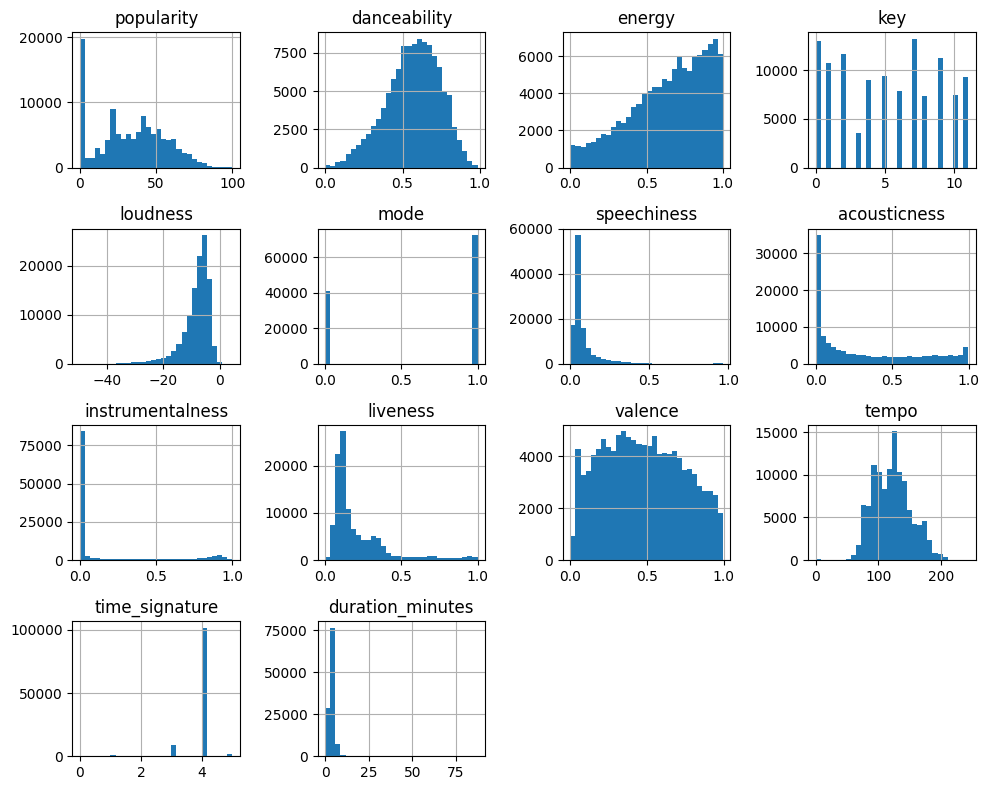

In [9]:
df[numerical_features].hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()

Из вышеуказанных графиков понимаем, что:

**Acousicness** имеет значения от 0.0 до 1.0, но большинство значений находятся близко к 0. Песни с высокой акустичностью чаще всего представляют собой классическую или народную музыку.

**Danceability** имеет значения от 0.0 до 1.0, и большинство значений сосредоточено около 0.7, с небольшой частью значений на крайних концах (0 и 1).

**Duration_minutes** принимает значения от 0 до 100. Ниже рассмотрим поближе.

**Energy** имеет значения от 0.0 до 1.0. Видим, что плотность песен с энергией менее 0.5 очень низкая.

**Instrumentalness** имеет значения от 0.0 до 1.0. Эта переменная предсказывает, имеет ли песня вокал (чем ниже значение, тем выше вероятность наличия вокала). Мы видим, что большинство песен имеют значение близкое к 0, что означает, что большинство песен содержат вокальные компоненты.

**Key(Тональность)** имеет значения от 0 до 12, где 0 соответствует C, а 12 — B. 

**Liveness** содержит значения от 0.0 до 1.0, где более высокие значения означают большее присутствие аудитории в записи. Мы видим, что большинство песен имеют **liveness** близкое к 0.

**Loudness** имеет значения от 0.0 до 1.0, и мы видим, что большинство песен имеют громкость около -10 дБ. Здесь 0 дБ — это нормальный стандарт для человеческого слуха.

**Mode** имеет два значения: 0 и 1. Мы видим, что большинство песен имеют радостный тон, так как они находятся в мажорном режиме (**mode**=1), который обычно звучит радостно (за исключением некоторых случаев).

**Speechiness** имеет значения от 0.0 до 1.0, и мы видим, что большинство песен имеют показатель **speechiness** меньше 0.25.

**Tempo** в основном содержит значения от 100 до 250. Видно, что статистическая мода для темпа находится около 125.

**Valence (Эмоциональная окраска)** имеет значения от 0.0 до 1.0. Видим, что большинство песен имеют значение **valence** менее 0.5, что указывает на менее радостный тон в большинстве песен.

**Time_signature (Ритмический размер)**: содержит значения от 1 до 5. Большинство значений равно 4, что типично для популярной музыки. Этот признак можно использовать, но, скорее всего, влияние на популярность будет незначительным.

**Popularity** принимает значения от 0.0 до 100.0. Большинство треков остаются незамеченными.

Рассмотрим поближе график длительности

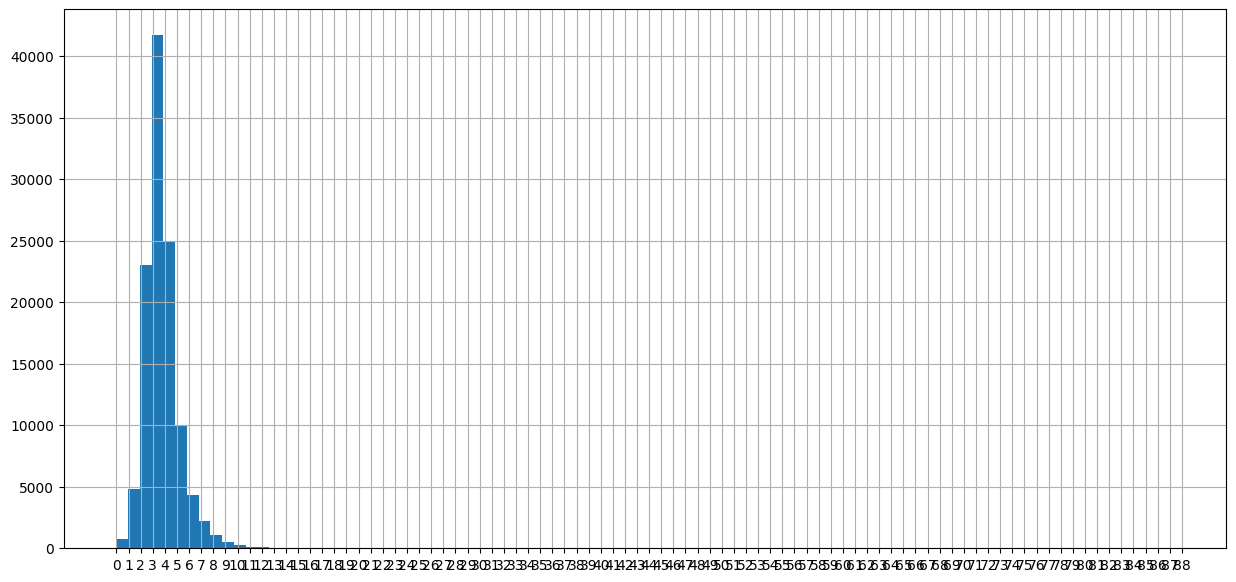

In [10]:
df['duration_minutes'].hist(figsize=(15, 7), bins=90)
# Настройка меток на оси X
plt.xticks(np.arange(0, df['duration_minutes'].max() + 1, step=1))

plt.show()

большинство треков имеют длительность от 2 до 4 минут

#### Построим те же графики, но для 1000 самых популярных треков

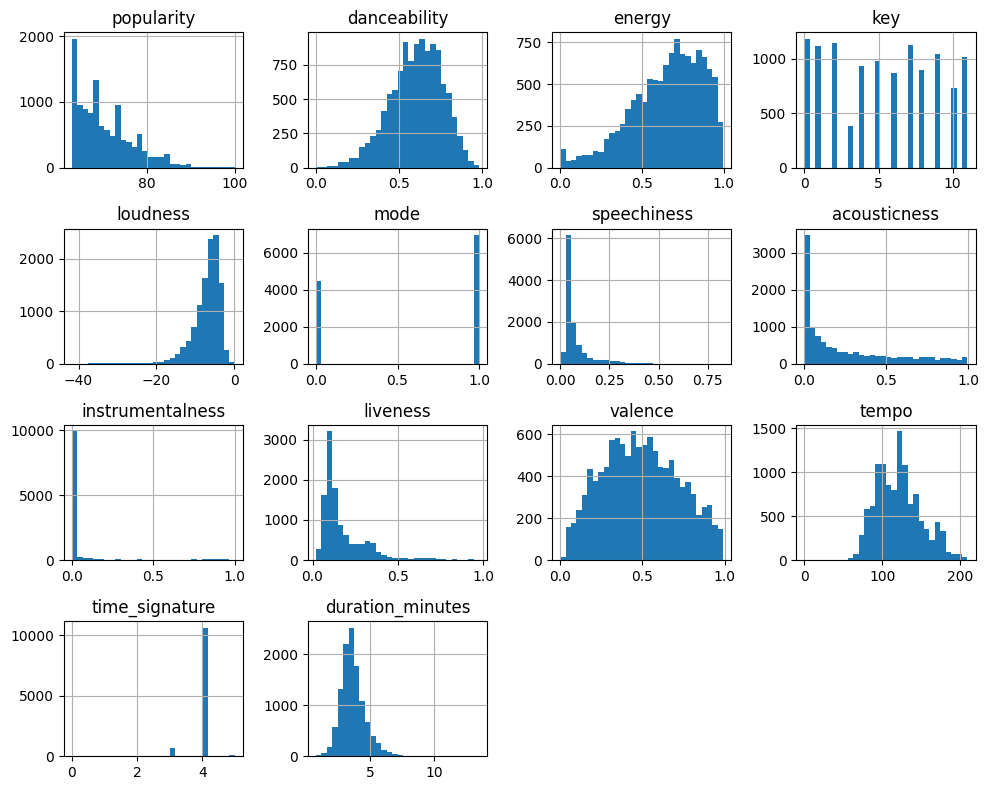

In [11]:
threshold = df['popularity'].quantile(0.9)
# Отбираем строки, у которых значение 'popularity' выше или равно порогу
top_10_percent = df[df['popularity'] >= threshold]

top_10_percent[numerical_features].hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()

Отобразим их вместе

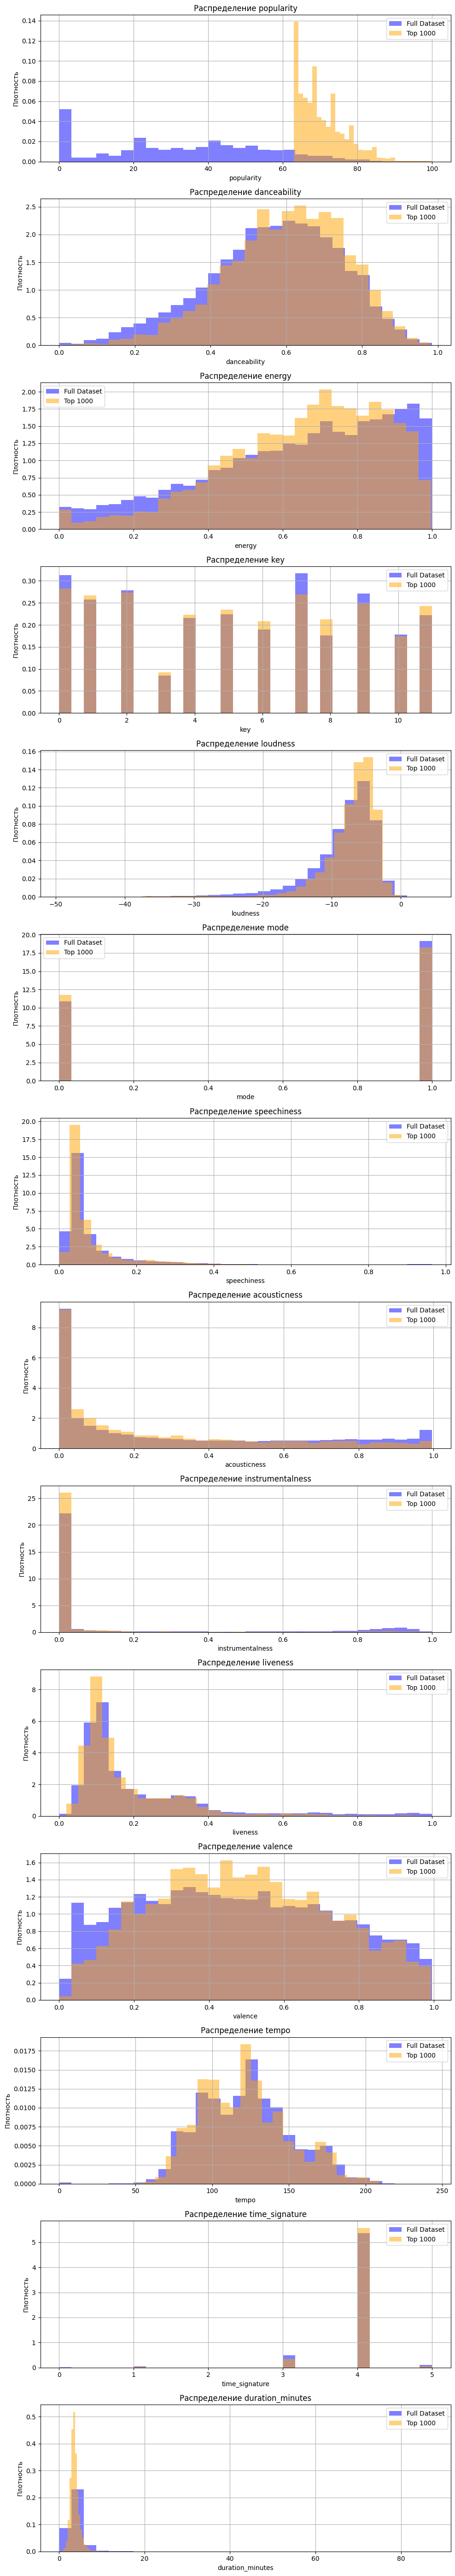

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 4 * len(numerical_features)), sharex=False)

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    
    df[feature].hist(ax=ax, bins=30, alpha=0.5, label='Full Dataset', color='blue', density=True)
    
    top_10_percent[feature].hist(ax=ax, bins=30, alpha=0.5, label='Top 1000', color='orange', density=True)
    
    # Добавляем заголовки и легенды
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Плотность')
    ax.legend()

# Подгоняем макет
plt.tight_layout()
plt.show()


Можно сделать вывод что у самых популярных треков, по сравнению с общей массой: energy от 0.5 до 0.9, danceability > 0.7, valence от 0.3 до 0.6, а также высокий показатель loudness. Это поможет при создании новых признаков.

#### Зависимость популярности от количества треков у исполнителя

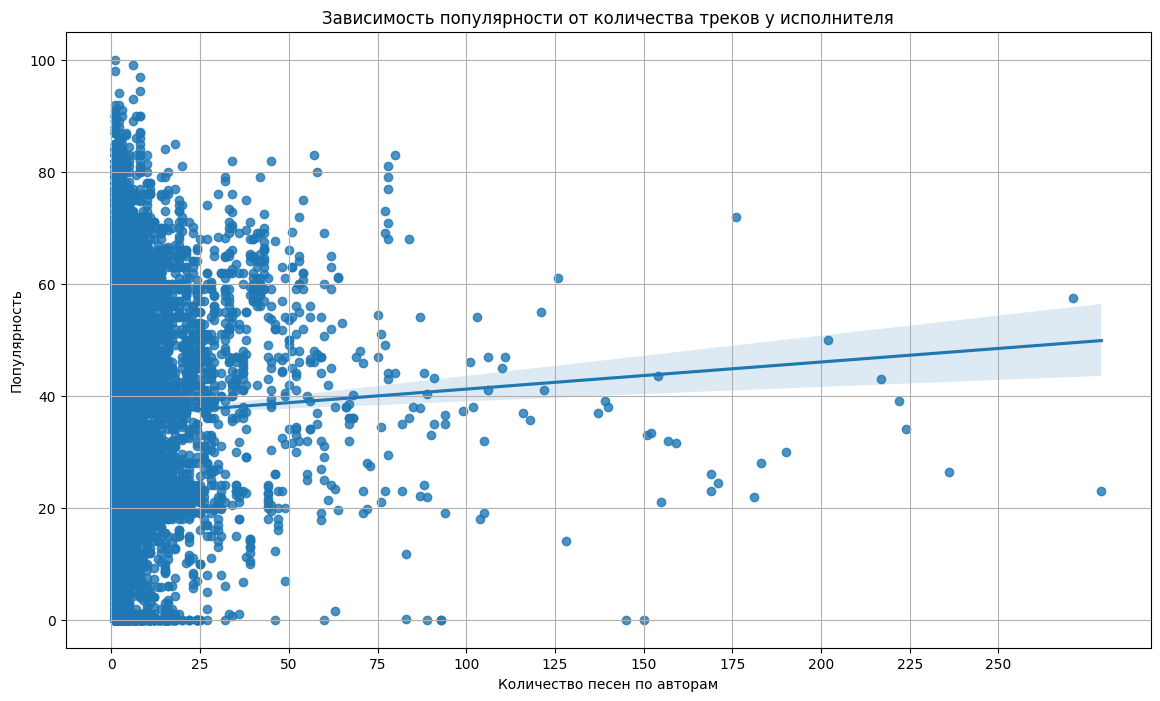

In [13]:
mean_artist_popularity = df.groupby('artists')['popularity'].mean()

plt.figure(figsize=(14, 8))
plt.grid(True)
plt.xticks([i for i in range(0, 275, 25)])
sns.regplot(y=mean_artist_popularity, x=df['artists'].value_counts())
plt.title('Зависимость популярности от количества треков у исполнителя')
plt.ylabel('Популярность')
plt.xlabel('Количество песен по авторам')

plt.show()

Можно сделать вывод, что чем больше песен у автора, тем выше средняя популярность его треков

#### Зависимость популярности от количества исполнителей

In [14]:
num_artists = df['artists'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 1)

print(num_artists.value_counts())

artists
1    113727
2       260
3        13
Name: count, dtype: int64


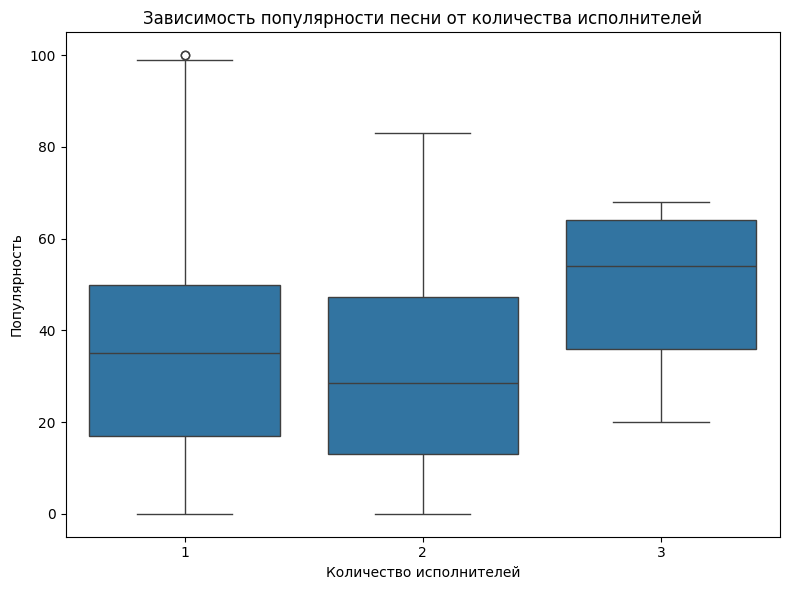

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=num_artists, y='popularity', data=df)
plt.title('Зависимость популярности песни от количества исполнителей')
plt.xlabel('Количество исполнителей')
plt.ylabel('Популярность')
plt.tight_layout()
plt.show()

На графике видно, что количество исполнителей оказывает малое влияние на популярность песни. Однако треки с тремя исполнителями, в среднем, имеют большую популярность по сравнению с песнями, в которых участвует меньше исполнителей.

Тем не менее, количество треков с двумя или тремя исполнителями значительно ниже, чем с одним исполнителем. Поэтому добавление этого признака в модель вряд ли значительно улучшит её точность.

#### Зависимость популярности песни от наличия брани

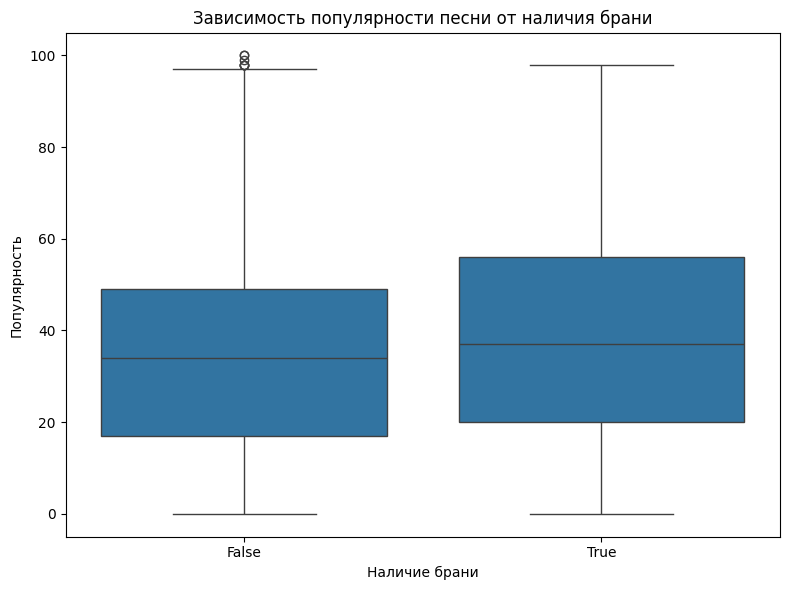

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='explicit', y='popularity', data=df)
plt.title('Зависимость популярности песни от наличия брани')
plt.xlabel('Наличие брани')
plt.ylabel('Популярность')
plt.tight_layout()
plt.show()

Песли с наличием и отсутствием нецензурной лексики имеют примерно одинаковый средний уровень популярности

### Добавим новые признаки

#### Категории танцевальности

In [17]:
df['danceability_category'] = pd.cut(df['danceability'], bins=[0,0.4,0.7,1],labels=['low','balanced','high'])

- **low (низкая танцевальность)**:
	Танцевальность находится в диапазоне от 0 до 0.4.
	Такие треки, скорее всего, обладают менее выраженным ритмом или мелодией, которая не предназначена для танцев.
	Примеры: спокойные, медленные или акустические композиции.

- **balanced (сбалансированная танцевальность)**:
	Танцевальность в диапазоне от 0.4 до 0.7.
	Эти треки имеют умеренный или высокий ритм, подходящий для танцев, но не обязательно исключительно "танцевальные".
	Примеры: поп, рок или R&B с умеренно выраженным ритмом.

- **high (высокая танцевальность)**:
	Танцевальность находится в диапазоне от 0.7 до 1.
	Такие треки сильно ориентированы на танцы, имеют четкий ритм, энергичные биты и минимальное количество "пустых" моментов.

#### Категории энергичности

In [18]:
df['energy_category'] = pd.cut(df['energy'], bins=[0,0.5,0.9,1],labels=['low','balanced','high'])

- **low (низкая энергия)**:  
  Энергия в диапазоне от 0 до 0.5.  
  Такие треки характеризуются мягким и расслабляющим звучанием, с минимальной динамикой или интенсивностью.  

- **balanced (сбалансированная энергия)**:  
  Энергия в диапазоне от 0.5 до 0.9.  
  Треки с умеренной энергией, которые могут сочетать ритмичность и спокойствие, создавая баланс.   

- **high (высокая энергия)**:  
  Энергия в диапазоне от 0.9 до 1.  
  Такие треки обладают высокой интенсивностью, энергичными битами и сильной динамикой, часто используются для подвижных или активных мероприятий.  


#### Категории эмоциональной окраски

In [19]:
df['valence_category'] = pd.cut(df['valence'], bins=[0,0.3,0.6,1],labels=['low','balanced','high'])

- **low (низкая эмоциональная окраска)**:  
  Эмоциональная окраска (valence) в диапазоне от 0 до 0.3.  
  Такие треки обычно обладают мрачным, грустным или меланхоличным звучанием. Они могут передавать глубокие, серьезные или задумчивые эмоции.  

- **balanced (сбалансированная эмоциональная окраска)**:  
  Эмоциональная окраска в диапазоне от 0.3 до 0.6.  
  Эти треки имеют нейтральную эмоциональную составляющую, что делает их подходящими как для фона, так и для более широкого спектра настроений.  

- **high (высокая эмоциональная окраска)**:  
  Эмоциональная окраска в диапазоне от 0.6 до 1.  
  Такие треки звучат ярко, радостно и оптимистично, часто ассоциируются с позитивными эмоциями и энергичными моментами.

#### Индекс настроения трека

In [20]:
df['emotion_index'] = df['valence'] * df['energy']

Мера "настроения" трека: умножаем valence (насколько трек веселый) на energy (энергичность).

#### Имеет ли автор много песен

In [21]:
artist_song_counts = df['artists'].value_counts()

df['songs_counts_per_artist'] = df['artists'].map(lambda artist: artist_song_counts[artist])

Мера того насколько у автора много песен

#### Акустическая сложность


In [22]:
df['acoustic_complexity'] = df['acousticness'] * df['instrumentalness']

Характеризует сложность звукового профиля трека, учитывая акустические и инструментальные составляющие. Может быть важным для анализа нишевых жанров.


#### Эмоциональная интенсивность


In [23]:
df['emotional_intensity'] = df['emotion_index'] * df['loudness']

Умножение показателя настроения на громкость трека. Это может отражать эмоциональное воздействие трека на слушателя.


#### Сложность трека

In [24]:
df['complexity_score'] = (df['instrumentalness'] + df['acousticness']) / (df['tempo'] + 1)

Скомбинируем три признака: instrumentalness, acousticness и tempo. 


#### Плотность речи

In [25]:
df['speech_density'] = df['speechiness'] / df['duration_minutes']

Соотношение speechiness к длительности трека: чем выше speechiness, тем больше слов в треке. Делим на duration_minutes, чтобы получить плотность текста за минуту.


#### Словесная выразительность

In [26]:
df['lyrical_expression'] = df['speech_density'] * df['valence']

Оценивает, насколько текст трека связан с эмоциональной составляющей. Это может быть полезно для анализа текстоориентированной музыки.


Так как в новых признаках есть операция деления, проверим их на невалидные значения

In [27]:
new_features = ['speech_density', 'complexity_score', 'lyrical_expression']

print("Проверка на NaN значения:")
print(df[new_features].isna().sum())

print("\nПроверка на бесконечные значения (inf):")
print(df[new_features].apply(lambda x: np.isinf(x).sum()))


Проверка на NaN значения:
speech_density        0
complexity_score      0
lyrical_expression    0
dtype: int64

Проверка на бесконечные значения (inf):
speech_density        1
complexity_score      0
lyrical_expression    1
dtype: int64


В speech_density есть одно бесконечное значение. Исправим это

In [28]:
df[new_features] = df[new_features].replace([np.inf, -np.inf], np.nan)
df[new_features] = df[new_features].fillna(df[new_features].mean())

print("\nПроверка на бесконечные значения (inf):")
print(df[new_features].apply(lambda x: np.isinf(x).sum()))


Проверка на бесконечные значения (inf):
speech_density        0
complexity_score      0
lyrical_expression    0
dtype: int64


### Уберем числовые признаки, для которых есть категориальные аналоги

In [29]:
df = df.drop(['danceability', 'energy', 'valence'], axis=1)

df.columns.tolist()

['artists',
 'album_name',
 'popularity',
 'explicit',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'tempo',
 'time_signature',
 'track_genre',
 'duration_minutes',
 'danceability_category',
 'energy_category',
 'valence_category',
 'emotion_index',
 'songs_counts_per_artist',
 'acoustic_complexity',
 'emotional_intensity',
 'complexity_score',
 'speech_density',
 'lyrical_expression']

### Преобразуем категорильные признаки

In [30]:
from sklearn.preprocessing import LabelEncoder

numerical_features = df.select_dtypes(include=['number','float64','int64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object','category']).columns.tolist()


# Применяем Label Encoding для каждого категориального признака

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Проверяем, что все признаки теперь числовые
df.dtypes


artists                      int64
album_name                   int64
popularity                   int64
explicit                      bool
key                          int64
loudness                   float64
mode                         int64
speechiness                float64
acousticness               float64
instrumentalness           float64
liveness                   float64
tempo                      float64
time_signature               int64
track_genre                  int64
duration_minutes           float64
danceability_category        int64
energy_category              int64
valence_category             int64
emotion_index              float64
songs_counts_per_artist      int64
acoustic_complexity        float64
emotional_intensity        float64
complexity_score           float64
speech_density             float64
lyrical_expression         float64
dtype: object

### Построим корреляционную матрицу


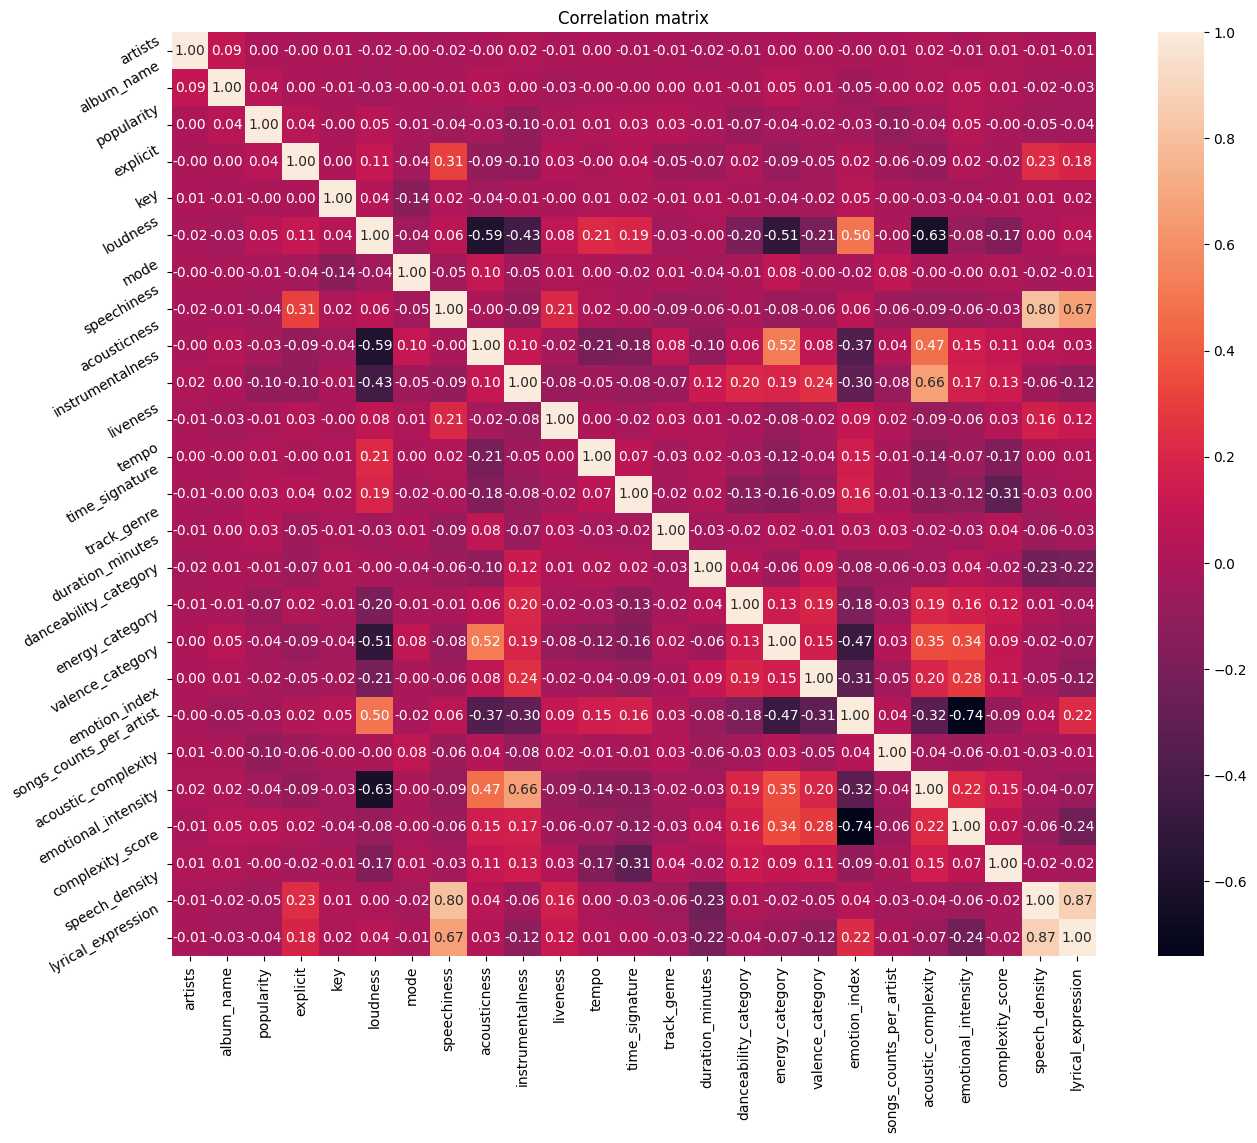

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
plt.title('Correlation matrix')
correlation = df.corr()
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()


Из матрицы видно что ни один из представленных признаков не имеет сильной линейной связи с популярностью. Это может говорить о том, что популярность песни определяется сложным набором факторов, которые не отражены в текущих признаках.

Слабая корреляция с популярностью говорит о том, что стандартные линейные методы, такие как линейная регрессия, могут быть недостаточно эффективны.
Для текущих признаков стоит попробовать нелинейные модели, такие как RandomForest, GradientBoosting или нейронные сети, которые могут лучше выявить скрытые зависимости.

## Эксперементы с моделями

### Нормализация данных

In [32]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Список числовых признаков для масштабирования
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove('popularity')  # Убираем целевую переменную из списка

X = df[numerical_features]
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Нормализация с StandardScaler
standard_scaler = StandardScaler()
X_train_standard = standard_scaler.fit_transform(X_train)
X_test_standard = standard_scaler.transform(X_test)

Добавим функцию для оценки модели

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

def evaluate_model(y_true,y_pred):
	# Оценка модели
	mae = mean_absolute_error(y_true, y_pred)
	mse = mean_squared_error(y_true, y_pred)
	rmse = root_mean_squared_error(y_true, y_pred)  
	r2 = r2_score(y_true, y_pred)

	# Выводим результаты
	print(f"MAE: {mae}")
	print(f"MSE: {mse}")
	print(f"RMSE: {rmse}")
	print(f"R2: {r2}")


**MAE (Mean Absolute Error)** показывает среднюю абсолютную разницу между предсказанными и реальными значениями. Это метрика, которая интерпретируется как среднее отклонение предсказаний от реальных данных, выраженное в тех же единицах, что и целевая переменная. Чем меньше значение MAE, тем точнее модель.

**MSE (Mean Squared Error)** измеряет средний квадрат отклонения предсказанных значений от реальных. Она более чувствительна к большим ошибкам, чем MAE, поскольку квадратичное увеличение ошибки увеличивает вклад этих отклонений в общую метрику. Это может быть полезно, если важно учитывать крупные ошибки.

**RMSE (Root Mean Squared Error)** — это квадратный корень из MSE. Данная метрика выражается в тех же единицах, что и целевая переменная, что делает её более интерпретируемой, чем MSE, но она сохраняет его чувствительность к большим ошибкам.

**R2 (Коэффициент детерминации)** отражает долю дисперсии целевой переменной, которая объясняется моделью. Значение R2 лежит в диапазоне от 0 до 1, где 1 означает, что модель идеально предсказывает данные, а 0 — что модель не объясняет дисперсию целевой переменной вовсе. Значение R2 также может быть отрицательным, если модель хуже, чем базовая, которая всегда предсказывает среднее значение целевой переменной. 


### Нейроннаяя сеть

#### Создание и компиляция модели

In [34]:
import keras
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam

def create_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mse','mae'])
    
    return model


In [35]:
model = create_model()

model.summary()

c:\Users\user\Desktop\5 сем\нейронки\spotify\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,441 (52.50 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Обучение модели на тренировочных данных

In [36]:
history = model.fit(X_train_standard, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 977.3480 - mae: 25.1995 - mse: 977.3480 - val_loss: 486.6732 - val_mae: 18.2454 - val_mse: 486.6732
Epoch 2/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 506.3109 - mae: 18.6307 - mse: 506.3109 - val_loss: 477.7638 - val_mae: 18.0635 - val_mse: 477.7638
Epoch 3/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 497.6308 - mae: 18.4665 - mse: 497.6308 - val_loss: 473.4633 - val_mae: 17.9614 - val_mse: 473.4633
Epoch 4/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 490.8567 - mae: 18.2895 - mse: 490.8567 - val_loss: 469.0884 - val_mae: 17.8561 - val_mse: 469.0884
Epoch 5/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 484.9403 - mae: 18.1561 - mse: 484.9403 - val_loss: 469.1699 - val_mae: 17.8880 - val_mse: 469.1699
Epoch 6/100
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 481.3271 - mae: 18.0603 - mse: 481.3271 - val_loss: 466.2444 - val_mae: 17.7942 - val_mse: 466.2444
Epoch 7/100
2280/2280 ━━━━━━━━━━━━

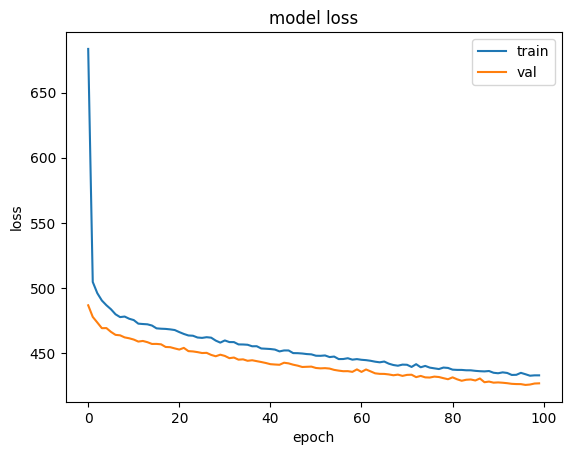

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

Модель успешно обучается, и качество её предсказаний улучшается как на тренировочных, так и на валидационных данных.

То, что линия train выше, указывает на то, что модель лучше оптимизирует ошибку на тренировочных данных по сравнению с валидационными, но разница невелика, что свидетельствует об отсутствии переобучения.

#### Оценка модели

In [38]:
y_pred_net = model.predict(X_test_standard)

evaluate_model(y_test, y_pred_net)

  1/713 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step
MAE: 16.639506576688667
MSE: 419.5848129636036
RMSE: 20.48376950084148
R2: 0.14974457025527954


#### Feature Importances

  1/713 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 919u

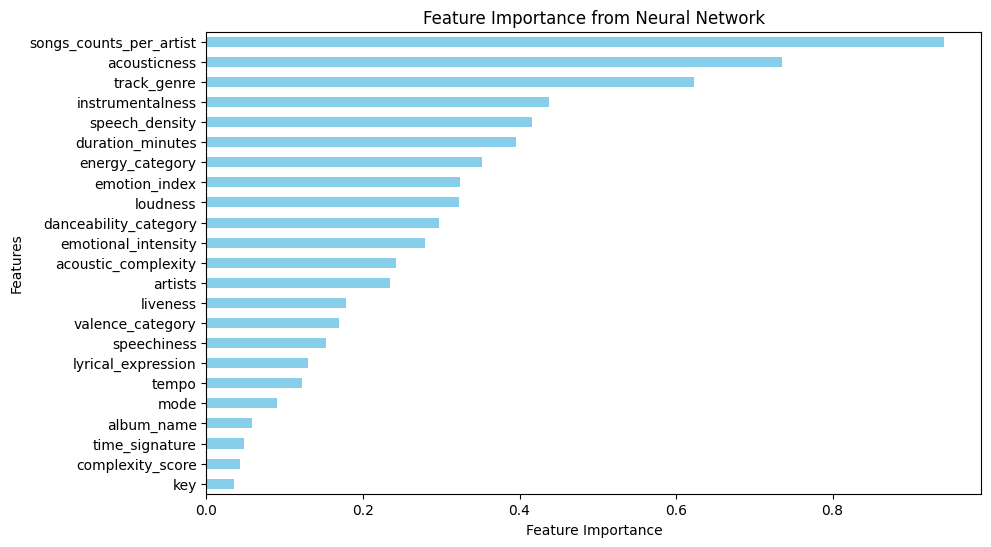

In [39]:
result = permutation_importance(model, X_test_standard, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')
importances = pd.Series(result.importances_mean, index=X.columns)

importances.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Feature Importance from Neural Network')
plt.xlabel('Feature Importance')
plt.ylabel('Features')

plt.show()

Одними из самых важных признаков оказались songs_counts_per_artist, acousticness и track_genre

### Линейная регрессия

In [40]:
from sklearn.linear_model import LinearRegression

# Создание модели LinearRegression
model_linear_regression = LinearRegression()

# Обучение модели
model_linear_regression.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_linear_regression = model_linear_regression.predict(X_test)

evaluate_model(y_test, y_pred_linear_regression)


MAE: 18.109985168712853
MSE: 474.20810374098005
RMSE: 21.77631979332091
R2: 0.03905476808676123


Как мы и предполагали, довольно слабый результат

#### Feature Importances

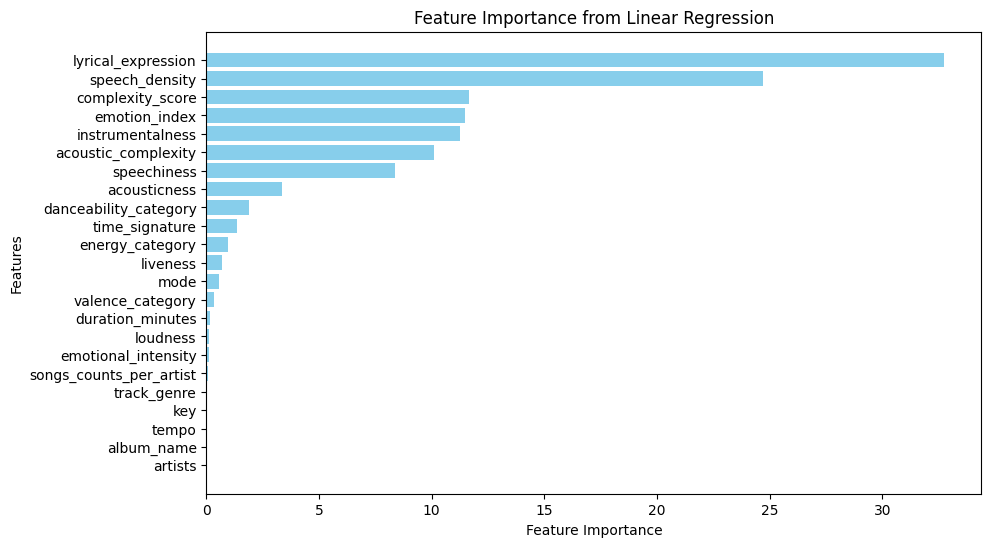

In [41]:
# Извлечение коэффициентов
coefficients = model_linear_regression.coef_

# Создание DataFrame
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Linear Regression')
plt.gca().invert_yaxis()
plt.show()

Для линейной регрессии важными параметрами оказались lyrical_expression и speech_density

### Случайный лес

In [42]:
from sklearn.ensemble import RandomForestRegressor

model_random_forest = RandomForestRegressor(n_estimators=50, criterion='friedman_mse',  random_state=42)

# Обучение модели
model_random_forest.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_random_forest = model_random_forest.predict(X_test)

# Оценка модели
evaluate_model(y_test, y_pred_random_forest)

MAE: 10.054845500208854
MSE: 192.6547653536478
RMSE: 13.88001316114822
R2: 0.6096003490630497


#### Feature Importances

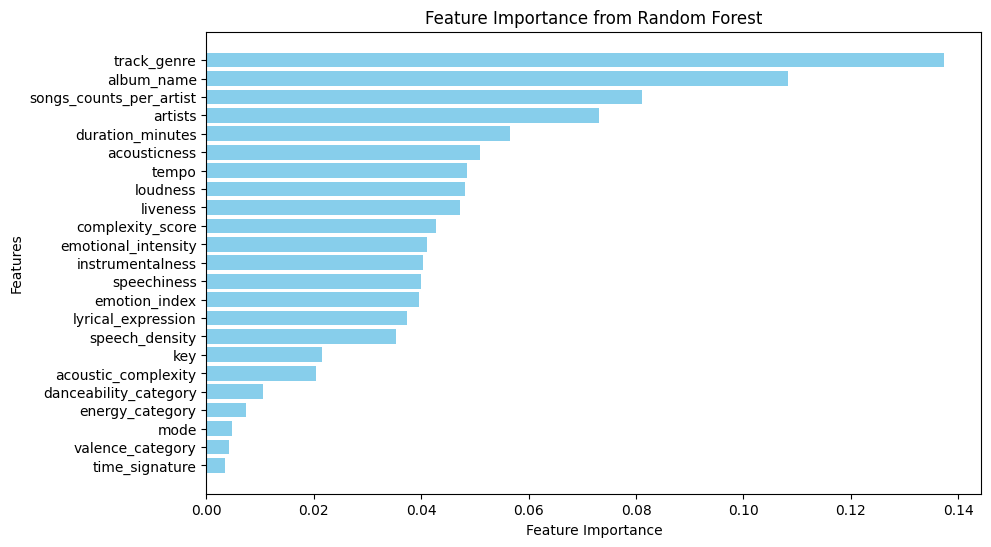

In [43]:
# Получение важности признаков
feature_importances = model_random_forest.feature_importances_

# Создание DataFrame для удобного отображения
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,  
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Самые важные признаки сверху
plt.show()


Для случайного леса важными параметрами оказались track_genre, album_name и songs_counts_per_artist

### Градиентный бустинг

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

# Создание модели GradientBoostingRegressor
model_boosting = GradientBoostingRegressor(n_estimators=25, max_depth=5, criterion='friedman_mse',  random_state=42)

# Обучение модели
model_boosting.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_boosting = model_boosting.predict(X_test)

# Оценка модели
evaluate_model(y_test, y_pred_boosting)

MAE: 16.219506141900816
MSE: 391.02529373688446
RMSE: 19.7743595025701
R2: 0.20761815622793445


#### Feature importance

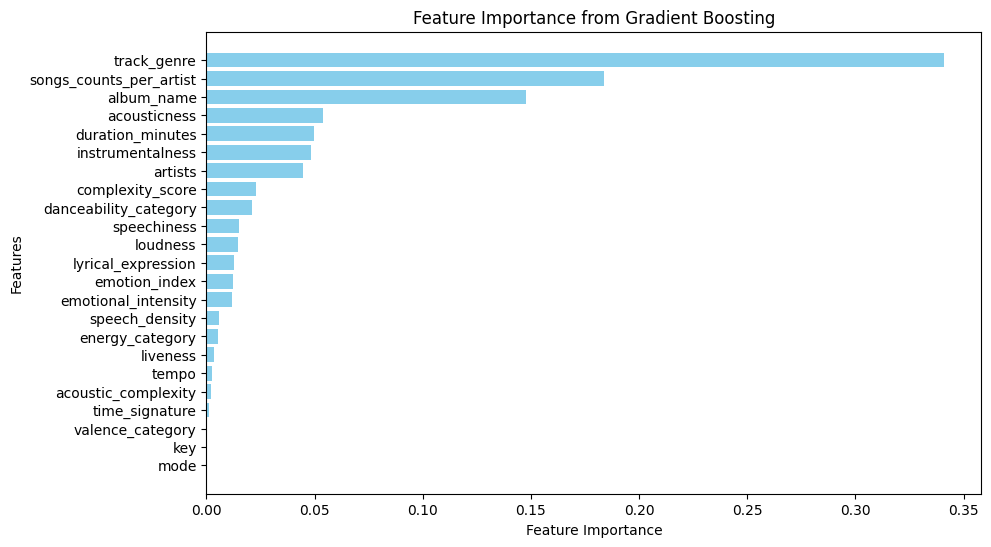

In [45]:
feature_importances = model_boosting.feature_importances_

# Создание DataFrame
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()

Для градиентного бустинга важными параметрами оказались track_genre, album_name и songs_counts_per_artist. Стоит отметить то, что для случайного леса эти параметры также являются самыми важными.

### Сравнение моделей

In [46]:
print('Нейронная сеть:' )
evaluate_model(y_test, y_pred_net)

print()
print('-'*20)
print()

print('Линейная регрессия:')
evaluate_model(y_test, y_pred_linear_regression)

print()
print('-'*20)
print()


print('Случайный лес:')
evaluate_model(y_test, y_pred_random_forest)

print()
print('-'*20)
print()


print('Градиентный бустинг:')
evaluate_model(y_test, y_pred_boosting)



Нейронная сеть:
MAE: 16.639506576688667
MSE: 419.5848129636036
RMSE: 20.48376950084148
R2: 0.14974457025527954

--------------------

Линейная регрессия:
MAE: 18.109985168712853
MSE: 474.20810374098005
RMSE: 21.77631979332091
R2: 0.03905476808676123

--------------------

Случайный лес:
MAE: 10.054845500208854
MSE: 192.6547653536478
RMSE: 13.88001316114822
R2: 0.6096003490630497

--------------------

Градиентный бустинг:
MAE: 16.219506141900816
MSE: 391.02529373688446
RMSE: 19.7743595025701
R2: 0.20761815622793445


На основании представленных метрик можно сделать следующие выводы о производительности каждой из моделей:

1. **Случайный лес (Random Forest)**:
   - Показал наилучшие результаты среди всех моделей. 
   - Минимальные значения MAE (10.05), MSE (192.65), и RMSE (13.88), что говорит о меньшей средней и квадратной ошибке.
   - Высокий коэффициент детерминации \(R^2 = 0.61\), что указывает на то, что модель хорошо объясняет вариацию целевой переменной.

2. **Градиентный бустинг (Gradient Boosting)**:
   - Занимает второе место по эффективности.
   - Ошибки (MAE: 16.22, MSE: 391.03, RMSE: 19.77) выше, чем у случайного леса, но всё ещё ниже, чем у других моделей.
   - Коэффициент детерминации \(R^2 = 0.21\), что лучше, чем у линейной регрессии и нейронной сети, но хуже, чем у случайного леса.

3. **Нейронная сеть**:
   - Дает результаты, сопоставимые с градиентным бустингом, но несколько уступает.
   - Ошибки (MAE: 16.45, MSE: 415.46, RMSE: 20.38) немного выше, чем у градиентного бустинга.
   - Коэффициент \(R^2 = 0.16\), что указывает на относительно слабую объяснительную способность.

4. **Линейная регрессия**:
   - Показала наихудшие результаты.
   - Самые высокие значения MAE (18.11), MSE (474.21), RMSE (21.78), что говорит о наибольших ошибках предсказания.
   - Самый низкий \(R^2 = 0.039\), что означает, что модель почти не объясняет вариацию целевой переменной.

### Итог:
- **Случайный лес** — оказалась самой эффективной моделью для данной задачи.
- **Градиентный бустинг** может быть альтернативой, если требуется немного меньшая сложность модели, но с некоторой потерей точности.
- **Нейронная сеть** и **линейная регрессия** оказались менее эффективными в данной задаче. Нейронную сеть можно улучшить за счёт подбора гиперпараметров или изменения структуры модели.

### Кросс валидация

In [47]:
# Установим число фолдов для кросс-валидации
cv_folds = 5

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Кросс-валидационные предсказания
y_pred_cv = cross_val_predict(model_random_forest, X_train_standard, y_train, cv=cv_folds)

# Вычисление метрик
mae = mean_absolute_error(y_train, y_pred_cv)
mse = mean_squared_error(y_train, y_pred_cv)
rmse = np.sqrt(mse)  # Корень из MSE
r2 = r2_score(y_train, y_pred_cv)

# Вывод результатов:
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

MAE: 10.7718
MSE: 215.7880
RMSE: 14.6897
R2: 0.5671


#### Вывод по результатам кросс-валидации:

После проведения кросс-валидации на 5 фолдах производительность модели немного ухудшилась по сравнению с первоначальными метриками на тестовых данных. 

- **MAE** увеличился с **10.05** до **10.77**, что указывает на возросшую среднюю ошибку.
- **MSE** вырос с **192.65** до **215.79**, что свидетельствует о большей чувствительности к крупным ошибкам.
- **RMSE** увеличился с **13.88** до **14.69**, что также подтверждает ухудшение точности.
- **R²** снизился с **0.61** до **0.57**, показывая, что объясняющая способность модели стала чуть хуже.

#### Итог:
Ухудшение метрик после кросс-валидации может быть связано с тем, что начальная оценка была оптимистичной из-за возможного переобучения на тренировочных данных. Кросс-валидация предоставила более объективную оценку модели, показывая, что случайный лес, хоть и остаётся лучшей моделью, имеет ограничения в обобщающей способности.

## Общий вывод

Предсказать популярность трека оказалось сложной задачей, поскольку результаты моделей показали, что популярность музыки во многом зависит от случайных факторов, которые не поддаются выявлению с помощью шаблонов или закономерностей, доступных для алгоритмов машинного обучения. Это отражает реальность, где успех трека зачастую определяется непредсказуемыми событиями.

В процессе работы я углубил свои знания в задачах регрессии и научился строить новые типы графиков. Я освоил различные подходы машинного обучения, включая линейные модели, случайный лес и градиентный бустинг, а также успешно обучил их. В завершение я провёл анализ и сравнение эффективности моделей, включая нейронные сети, и использовал кросс-валидацию для объективной оценки их производительности.